In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dense, Reshape, Flatten, Dropout, LeakyReLU, Input, Embedding, Concatenate, Conv2DTranspose, Conv2D
from tensorflow.keras.layers import BatchNormalization, multiply, Activation
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam

In [2]:
# Load MNIST data
(train_images, train_labels), (_, _) = mnist.load_data()

# Normalize the images
train_images = (train_images - 127.5) / 127.5
train_images = np.expand_dims(train_images, axis=-1)

In [3]:
# Generator model
def build_generator(latent_dim, num_classes):
    noise = Input(shape=(latent_dim,))
    label = Input(shape=(1,))
    label_embedding = Flatten()(Embedding(num_classes, latent_dim)(label))

    model_input = multiply([noise, label_embedding])
    model = Dense(7 * 7 * 128, activation="relu")(model_input)
    model = Reshape((7, 7, 128))(model)
    model = Conv2DTranspose(128, kernel_size=4, strides=2, padding="same")(model)
    model = BatchNormalization()(model)
    model = Activation("relu")(model)
    model = Conv2DTranspose(64, kernel_size=4, strides=2, padding="same")(model)
    model = BatchNormalization()(model)
    model = Activation("relu")(model)
    generated_image = Conv2DTranspose(1, kernel_size=7, padding="same", activation="tanh")(model)

    return Model([noise, label], generated_image)

# Discriminator model
def build_discriminator(img_shape, num_classes):
    image = Input(shape=img_shape)
    label = Input(shape=(1,))
    label_embedding = Flatten()(Embedding(num_classes, np.prod(img_shape))(label))
    label_embedding = Reshape(img_shape)(label_embedding)

    model_input = Concatenate()([image, label_embedding])
    model = Conv2D(64, kernel_size=3, strides=2, padding="same")(model_input)
    model = LeakyReLU(alpha=0.2)(model)
    model = Dropout(0.4)(model)
    model = Conv2D(128, kernel_size=3, strides=2, padding="same")(model)
    model = LeakyReLU(alpha=0.2)(model)
    model = Dropout(0.4)(model)
    model = Flatten()(model)
    validity = Dense(1, activation='sigmoid')(model)

    return Model([image, label], validity)

In [4]:
# Set parameters
latent_dim = 100
num_classes = 10
img_rows, img_cols, channels = 28, 28, 1
img_shape = (img_rows, img_cols, channels)
img_shape

(28, 28, 1)

In [5]:
# Build and compile the discriminator
discriminator = build_discriminator(img_shape, num_classes)
discriminator.compile(optimizer=Adam(learning_rate=0.0002, beta_1=0.5),
                      loss='binary_crossentropy',
                      metrics=['accuracy'])

In [6]:
# Build the generator
generator = build_generator(latent_dim, num_classes)

In [7]:
# The generator takes noise and the target label as input
noise = Input(shape=(latent_dim,))
label = Input(shape=(1,))
generated_image = generator([noise, label])

In [8]:
# For the combined model, only train the generator
discriminator.trainable = False

# The discriminator takes generated images and the target label as input and determines validity
validity = discriminator([generated_image, label])

In [9]:
# Combined (generator and discriminator) model
combined = Model([noise, label], validity)
combined.compile(optimizer=Adam(learning_rate=0.0002, beta_1=0.5),
                 loss='binary_crossentropy')

In [17]:
# Training the CGAN
epochs = 20000
batch_size = 32
half_batch = batch_size // 2

In [18]:
for epoch in range(epochs):
    # Train discriminator
    idx = np.random.randint(0, train_images.shape[0], half_batch)
    imgs, labels = train_images[idx], train_labels[idx]

    noise = np.random.normal(0, 1, (half_batch, latent_dim))
    gen_imgs = generator.predict([noise, labels])

    d_loss_real = discriminator.train_on_batch([imgs, labels], np.ones((half_batch, 1)))
    d_loss_fake = discriminator.train_on_batch([gen_imgs, labels], np.zeros((half_batch, 1)))
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # Train generator
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    sampled_labels = np.random.randint(0, 10, batch_size).reshape(-1, 1)

    g_loss = combined.train_on_batch([noise, sampled_labels], np.ones((batch_size, 1)))

    # Print progress
    if epoch % 100 == 0:
        print(f"Epoch {epoch}: [D loss: {d_loss[0]}, acc.: {100 * d_loss[1]}] [G loss: {g_loss}]")


1/1 [==============================] - 0s 25ms/step
Epoch 0: [D loss: 0.0013771731173619628, acc.: 100.0] [G loss: 2.1566040231846273e-05]
1/1 [==============================] - 0s 23ms/step
Epoch 100: [D loss: 0.000873924174811691, acc.: 100.0] [G loss: 6.186369137139991e-05]
1/1 [==============================] - 0s 21ms/step
Epoch 200: [D loss: 0.0032348594395443797, acc.: 100.0] [G loss: 0.0022192224860191345]
1/1 [==============================] - 0s 27ms/step
Epoch 300: [D loss: 0.014074374921619892, acc.: 100.0] [G loss: 4.7845988273620605]
1/1 [==============================] - 0s 20ms/step
Epoch 400: [D loss: 0.005094720399938524, acc.: 100.0] [G loss: 6.205351829528809]
1/1 [==============================] - 0s 20ms/step
Epoch 500: [D loss: 0.0015600789920426905, acc.: 100.0] [G loss: 6.7729597091674805]
1/1 [==============================] - 0s 21ms/step
Epoch 600: [D loss: 0.0006010332435835153, acc.: 100.0] [G loss: 7.411159515380859]
1/1 [==============================] -

In [19]:
# Generating new images
def generate_images(n_rows, n_cols, generator_model):
    noise = np.random.normal(0, 1, (n_rows * n_cols, latent_dim))
    #labels = np.tile(np.arange(0, 10).reshape(-1, 1), n_rows).reshape(-1, 1)
    labels = np.random.randint(0, num_classes, n_rows * n_cols).reshape(-1, 1)

    generated_images = generator_model.predict([noise, labels])
    generated_images = 0.5 * generated_images + 0.5  # Rescale images 0 - 1
    return generated_images

# Generate and plot images
import matplotlib.pyplot as plt

In [20]:
n_rows = 4
n_cols = 6
generated_images = generate_images(n_rows, n_cols, generator)

1/1 [==============================] - 0s 30ms/step


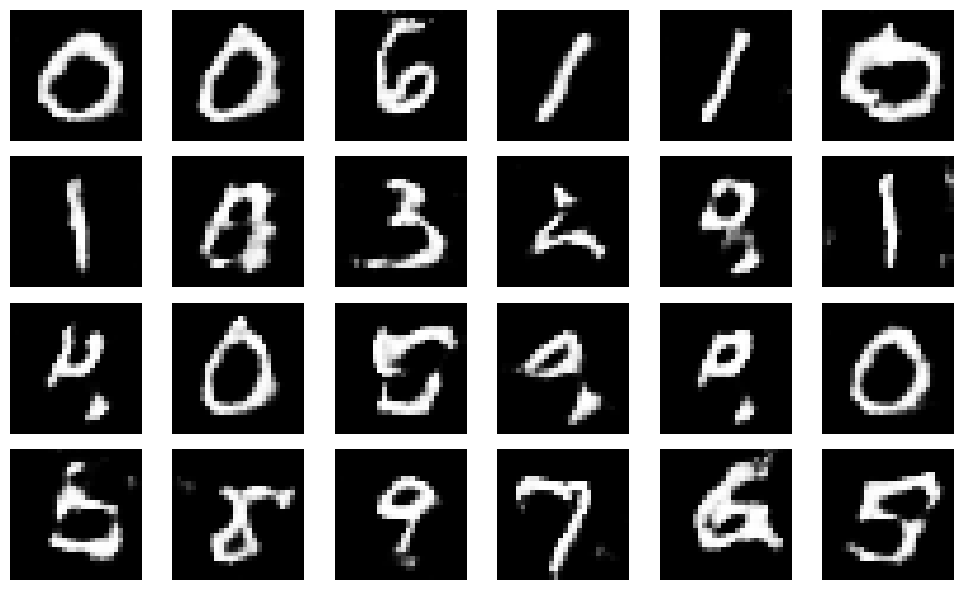

In [21]:
fig, axs = plt.subplots(n_rows, n_cols, figsize=(10, 6), sharex=True, sharey=True)
count = 0
for i in range(n_rows):
    for j in range(n_cols):
        axs[i, j].imshow(generated_images[count, :, :, 0], cmap='gray')
        axs[i, j].axis('off')
        count += 1
plt.tight_layout()
plt.show()
